<a href="https://colab.research.google.com/github/AliAlBadra/KerasTFImageClassificationCNN/blob/main/4_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare Environment

In [ ]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install patchify
!pip install scikit-learn==1.0.0
!pip install split-folders
!pip install gast==0.3.2
!pip install six==1.15.0
!pip install folium==0.2.1
!pip install imgaug==0.2.5
!pip install 'h5py<3.0.0'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cellseg_dir = '/content/drive/MyDrive/CellSeg/'
data_dir = cellseg_dir + "data/"
input_dir = data_dir + "input/"
original_input_dir = input_dir + "original/"
after_patchify_384_input_dir = input_dir + "after_patchify_384/"
after_patchify_256_input_dir = input_dir + "after_patchify_256/"
output_dir = data_dir + "output/"

#Import Data

In [4]:
# https://youtu.be/F365vQ8EndQ
"""
Author: Sreenivas Bhattiprolu

Multiclass semantic segmentation using U-Net with VGG, ResNet, and Inception 
as backbones

Segmentation models: https://github.com/qubvel/segmentation_models

To annotate images and generate labels, you can use APEER (for free):
www.apeer.com 
"""

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU


#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=2 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob(after_patchify_256_input_dir + "images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(after_patchify_256_input_dir + "masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [5]:

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [6]:
#################################################
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [7]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1]


In [8]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

#Compile & Train Models

In [ ]:
########################################################################
###Model 1
BACKBONE1 = 'efficientnetb4'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [ ]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model1.compile('Adam', loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=4, 
          epochs=5,
          verbose=1,
          validation_data=(X_test1, y_test_cat))



Train on 340 samples, validate on 76 samples
Epoch 1/5
340/340 [==============================] - 62s 181ms/sample - loss: 0.3872 - iou_score: 0.5204 - val_loss: 0.8993 - val_iou_score: 0.5115
Epoch 2/5
340/340 [==============================] - 36s 106ms/sample - loss: 0.2008 - iou_score: 0.7296 - val_loss: 0.7220 - val_iou_score: 0.6374
Epoch 3/5
340/340 [==============================] - 36s 105ms/sample - loss: 0.1765 - iou_score: 0.7669 - val_loss: 0.3863 - val_iou_score: 0.7062
Epoch 4/5
340/340 [==============================] - 36s 106ms/sample - loss: 0.1559 - iou_score: 0.7891 - val_loss: 0.1843 - val_iou_score: 0.7573
Epoch 5/5
340/340 [==============================] - 36s 106ms/sample - loss: 0.1463 - iou_score: 0.8033 - val_loss: 0.1707 - val_iou_score: 0.7866


In [ ]:
model1.save(cellseg_dir + 'model/full/EffNetB4_temp_backbone_5epochs.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


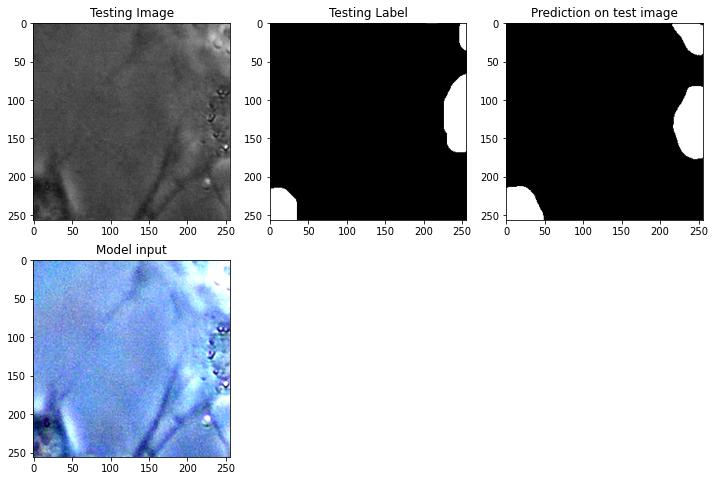

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

#test_img_input1 = preprocess_input1(test_img_input)
test_img_input1 = test_img_input
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.subplot(234)
plt.title('Model input')
plt.imshow(test_img_input1[0])
plt.show()

In [ ]:
print(np.unique(test_img_input1[0]))

[-2.1204479 -2.1198614 -2.119568  -2.119275  -2.1189816 -2.1186883
 -2.118395  -2.1178088 -2.1175153 -2.117222  -2.116929  -2.1166356
 -2.1163423 -2.116049  -2.1157558 -2.1154625 -2.1151693 -2.114876
 -2.1145828 -2.1142895 -2.1139963 -2.113703  -2.1134098 -2.1131165
 -2.1128232 -2.11253   -2.1122367 -2.1119435 -2.1116502 -2.111357
 -2.1110637 -2.1107705 -2.1104772 -2.110184  -2.1098907 -2.1095974
 -2.1093042 -2.109011  -2.1087177 -2.1084244 -2.1081312 -2.107838
 -2.1075447 -2.1072514 -2.1069582 -2.106665  -2.1063716 -2.1060784
 -2.1057851 -2.1054919 -2.1051986 -2.1049054 -2.104612  -2.1043189
 -2.1040256 -2.1037323 -2.103439  -2.1031458 -2.1028526 -2.1025593
 -2.102266  -2.1019728 -2.1016796 -2.1013863 -2.101093  -2.1007998
 -2.1005065 -2.1002133 -2.09992   -2.0996268 -2.0993335 -2.09904
 -2.098747  -2.0984538 -2.0981605 -2.0978673 -2.097574  -2.0972807
 -2.0969875 -2.096694  -2.096401  -2.0961077 -2.0958142 -2.0955212
 -2.0949345 -2.094348  -2.0937617 -2.092882  -2.0911222 -2.0908291


In [ ]:
############################################################
###Model 2

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model2.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model2.save('inceptionv3_backbone_50epochs.hdf5')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 128, 128, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 128, 128, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 128, 128, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
#####################################################
###Model 3

BACKBONE3 = 'vgg19'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

# define model
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model3.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


print(model3.summary())

history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))


model3.save('vgg19_backbone_50epochs.hdf5')

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
___________________________

In [ ]:
#####################################################
###Model 4

BACKBONE4 = 'densenet201'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train4 = preprocess_input3(X_train)
X_test4 = preprocess_input3(X_test)

# define model
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model4 = sm.Unet(BACKBONE4, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model4.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


print(model4.summary())

history4=model4.fit(X_train4, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test4, y_test_cat))


model4.save('densenet201_backbone_50epochs.hdf5')

74842112/74836368 [==============================] - 4s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
___________________________

In [ ]:
#####################################################
###Model 4

BACKBONE5 = 'resnet34'
preprocess_input5 = sm.get_preprocessing(BACKBONE5)

# preprocess input
X_train5 = preprocess_input5(X_train)
X_test5 = preprocess_input5(X_test) 

# define model
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model5 = sm.Unet(BACKBONE5, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model5.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


print(model5.summary())

history5=model5.fit(X_train5, 
          y_train_cat,
          batch_size=4, 
          epochs=5,
          verbose=1,
          validation_data=(X_test5, y_test_cat))


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_102 (ZeroPadding (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_102[0][0]         
____________________________________________________________________________________________

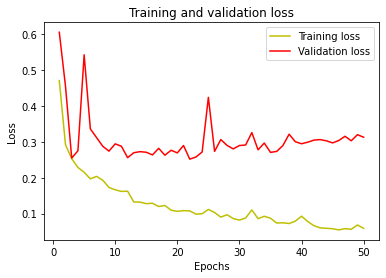

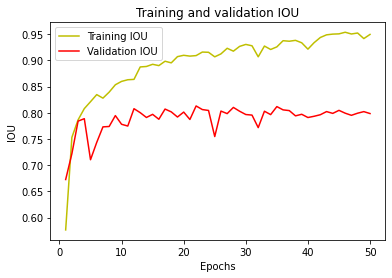

In [ ]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

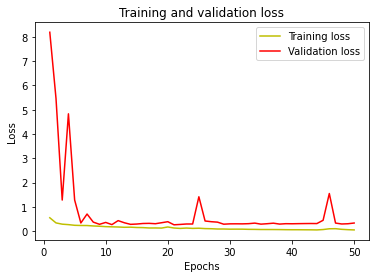

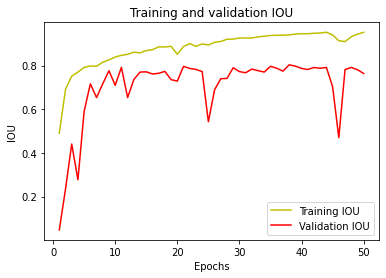

In [ ]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

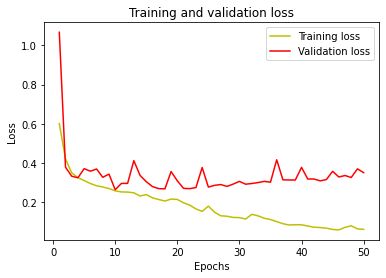

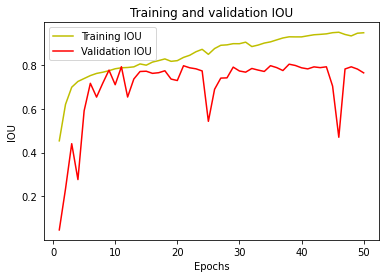

In [ ]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

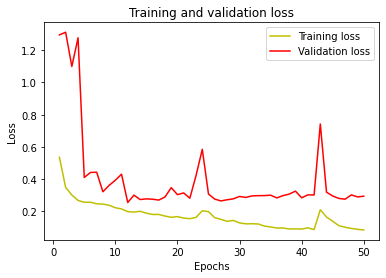

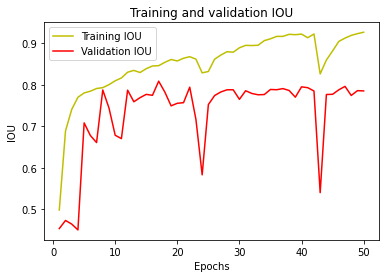

In [ ]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history4.history['iou_score']
val_acc = history4.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
from tensorflow import keras
import efficientnet.tfkeras
model = keras.models.load_model(cellseg_dir + 'model/full/densenet201_backbone_50epochs.hdf5', compile=False)


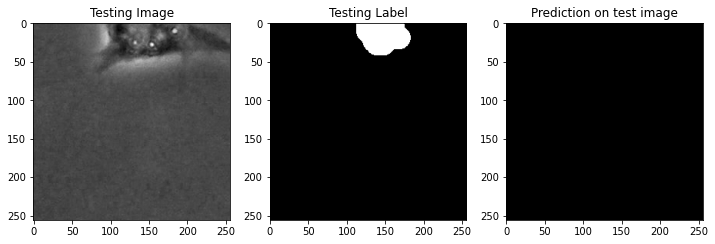

In [ ]:





#####################################################

from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
#model1 = load_model('saved_models/_backbone_50epochs.hdf5', compile=False)
#model2 = load_model('saved_models/inceptionv3_backbone_50epochs.hdf5', compile=False)
#model3 = load_model('saved_models/vgg19_backbone_50epochs.hdf5', compile=False)

#IOU
##############################################################
# preprocess input

BACKBONE1 = 'densenet201'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)


#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

#Load & Test Model

In [9]:
from tensorflow import keras
import efficientnet.tfkeras
DenseNetModel = keras.models.load_model(cellseg_dir + 'model/full/densenet201_backbone_50epochs.hdf5', compile=False)
EffNetModel = keras.models.load_model(cellseg_dir + 'model/full/EffNetB4_backbone_50epochs.hdf5', compile=False)
InceptionModel = keras.models.load_model(cellseg_dir + 'model/full/inceptionv3_backbone_50epochs.hdf5', compile=False)
VggModel = keras.models.load_model(cellseg_dir + 'model/full/vgg19_backbone_50epochs.hdf5', compile=False)

In [10]:
########################################################################
###Model 1
BACKBONE1 = 'efficientnetb4'
preprocess_EffNet = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_test_EffNet = preprocess_EffNet(X_test)

########################################################################
########################################################################
###Model 2
BACKBONE2 = 'densenet201'
preprocess_DenseNet = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_test_DenseNet = preprocess_DenseNet(X_test)

########################################################################
########################################################################
###Model 3
BACKBONE3 = 'inceptionv3'
preprocess_Inception = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_test_Inception = preprocess_Inception(X_test)

########################################################################
########################################################################
###Model 4
BACKBONE4 = 'vgg19'
preprocess_VGG = sm.get_preprocessing(BACKBONE4)

# preprocess input
X_test_VGG = preprocess_VGG(X_test)

########################################################################

40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


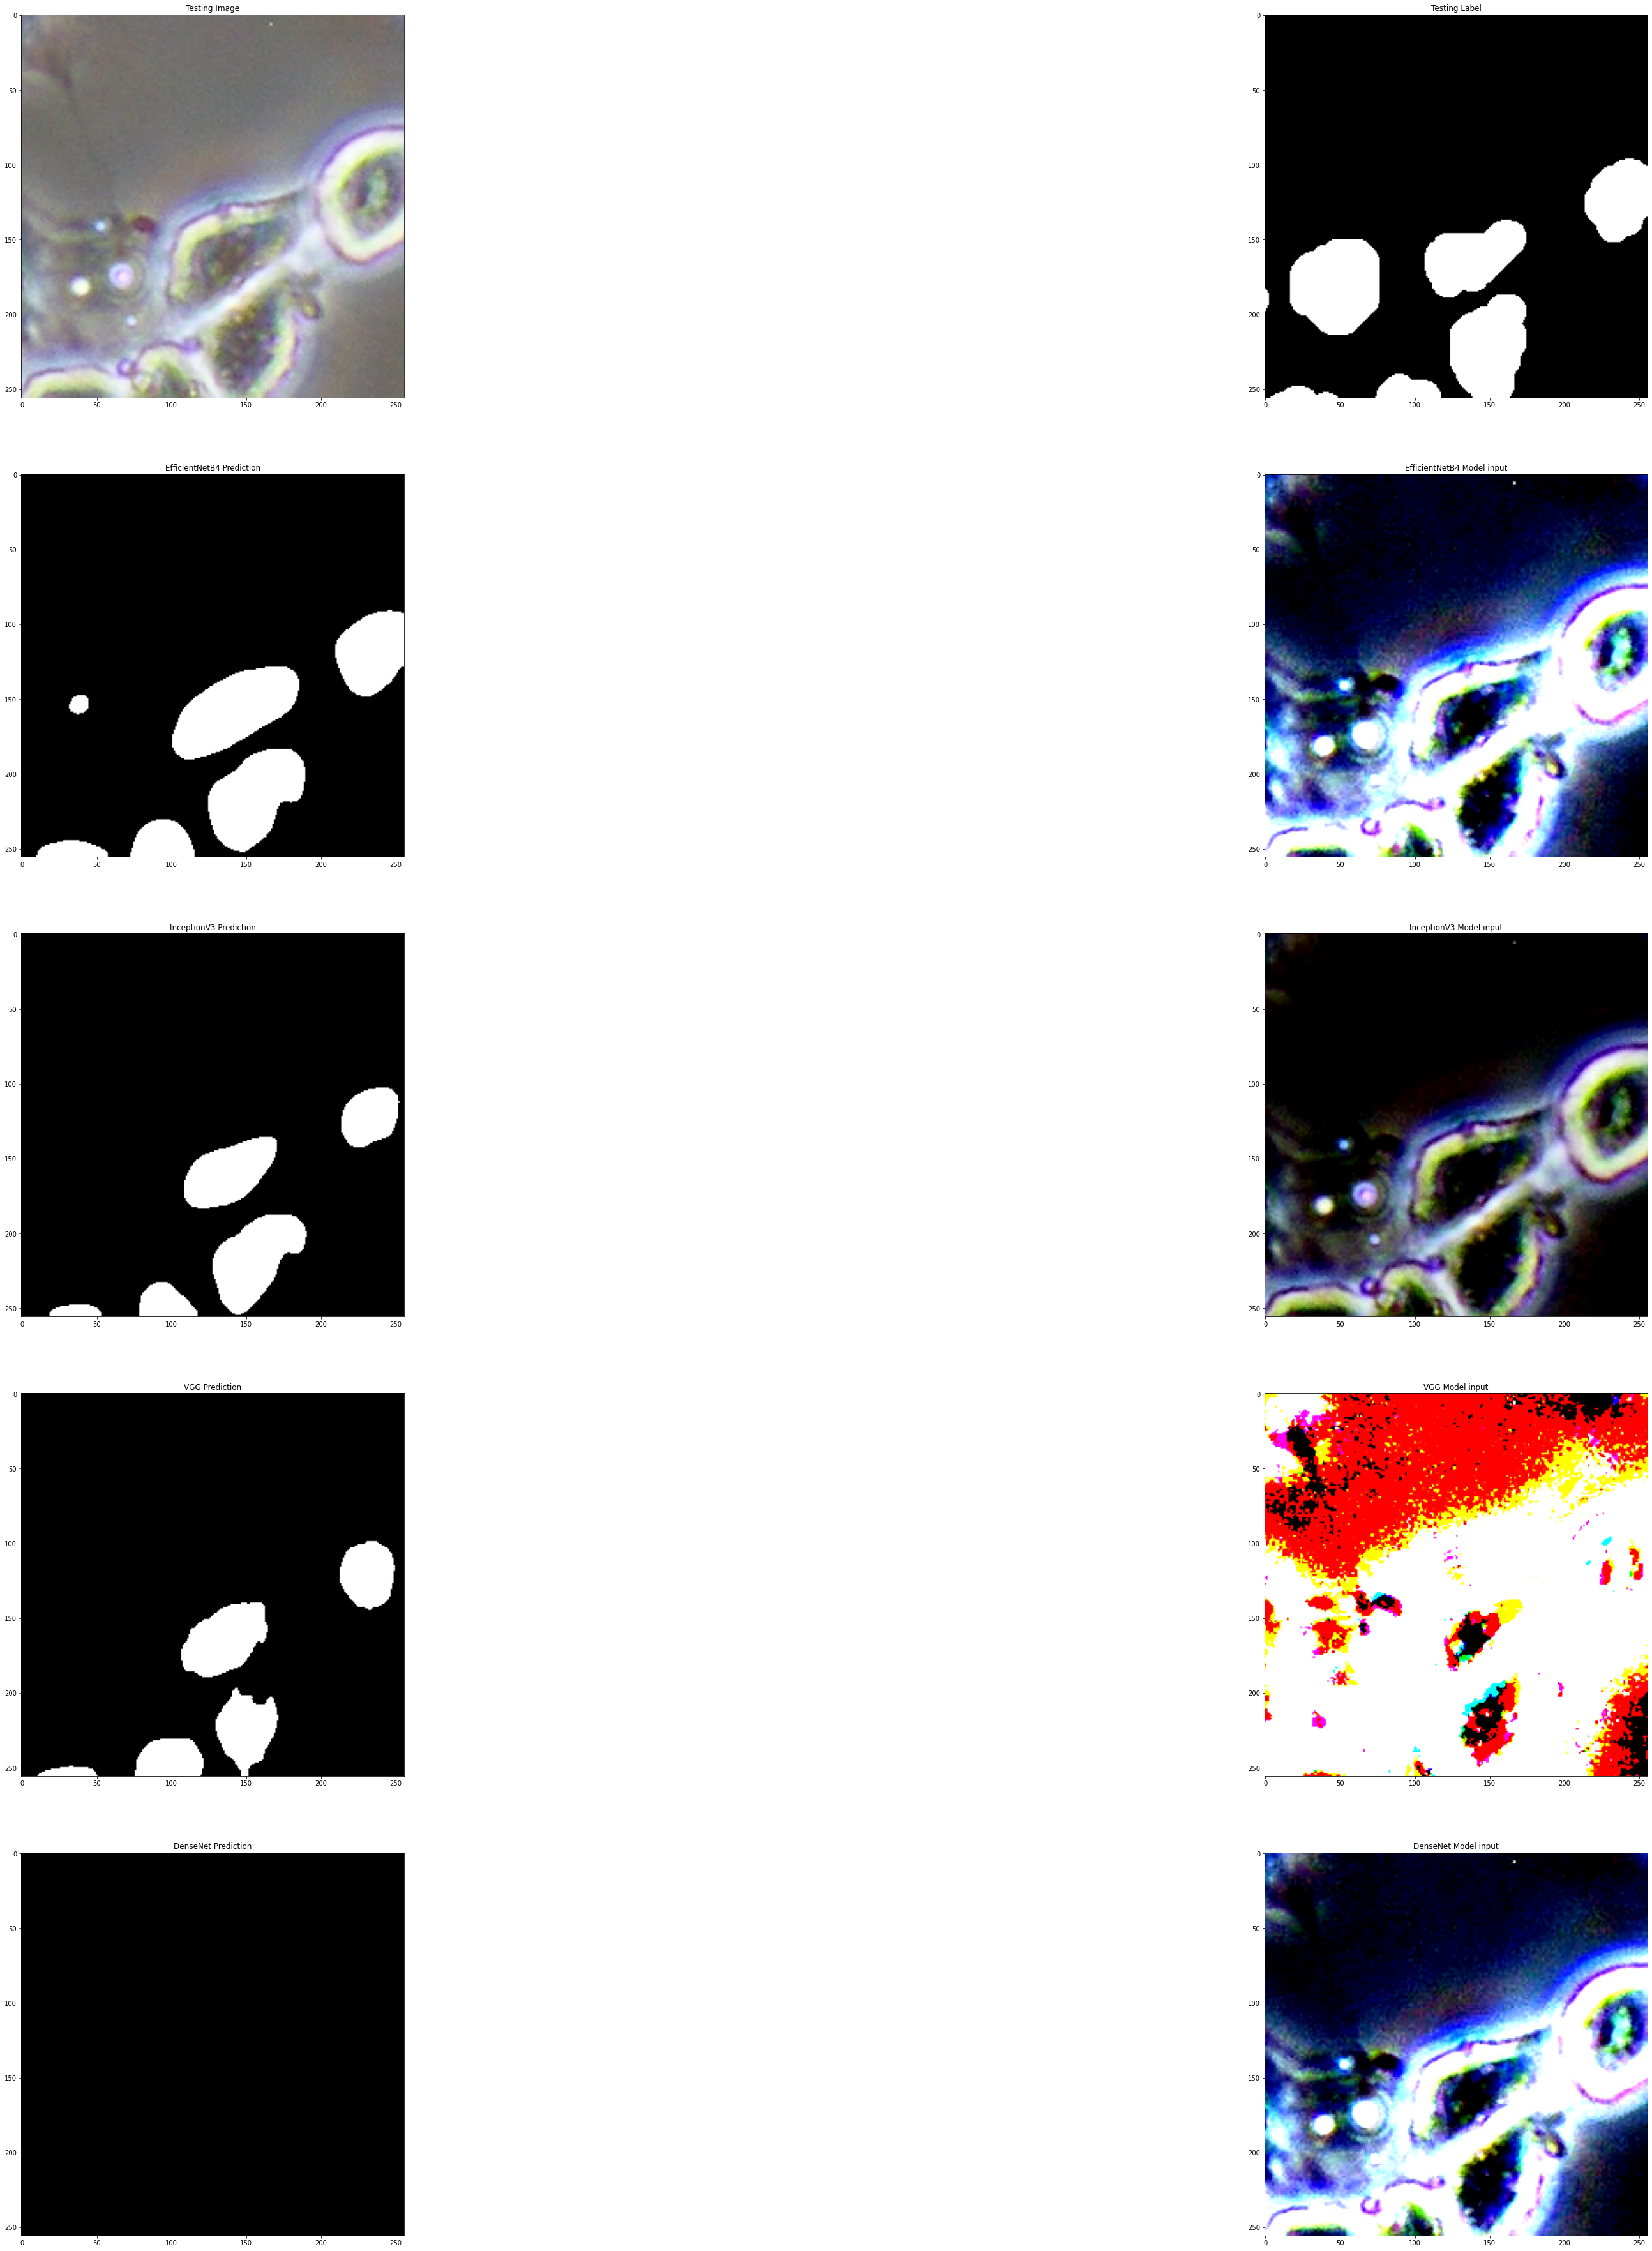

In [11]:
#Be careful not to pre-process twice.. check if you already pre-processed x_test in upper cells.

X_test_tmp = X_test_VGG
model_tmp = VggModel
#Test some random images
import random
test_img_number = random.randint(0, len(X_test_tmp))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
print(test_img_number)

#For each model
test_img_EffNet = X_test_EffNet[test_img_number]
test_img_input_EffNet=np.expand_dims(test_img_EffNet, 0)
test_pred1 = EffNetModel.predict(test_img_input_EffNet)
test_prediction_EffNet = np.argmax(test_pred1, axis=3)[0,:,:]

#For each model
test_img_DenseNet = X_test_DenseNet[test_img_number]
test_img_input_DenseNet=np.expand_dims(test_img_DenseNet, 0)
test_pred1 = DenseNetModel.predict(test_img_input_DenseNet)
test_prediction_DenseNet = np.argmax(test_pred1, axis=3)[0,:,:]

#For each model
test_img_VGG = X_test_VGG[test_img_number]
test_img_input_VGG=np.expand_dims(test_img_VGG, 0)
test_pred1 = VggModel.predict(test_img_input_VGG)
test_prediction_VGG = np.argmax(test_pred1, axis=3)[0,:,:]

#For each model
test_img_Inception = X_test_Inception[test_img_number]
test_img_input_Inception=np.expand_dims(test_img_Inception, 0)
test_pred1 = InceptionModel.predict(test_img_input_Inception)
test_prediction_Inception = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(64,64))
plt.subplot(5,2,1)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(5,2,2)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(5,2,3)
plt.title('EfficientNetB4 Prediction')
plt.imshow(test_prediction_EffNet, cmap='gray')
plt.subplot(5,2,4)
plt.title('EfficientNetB4 Model input')
plt.imshow(test_img_input_EffNet[0])
plt.subplot(5,2,5)
plt.title('InceptionV3 Prediction')
plt.imshow(test_prediction_Inception, cmap='gray')
plt.subplot(5,2,6)
plt.title('InceptionV3 Model input')
plt.imshow(test_img_input_Inception[0])
plt.subplot(5,2,7)
plt.title('VGG Prediction')
plt.imshow(test_prediction_VGG, cmap='gray')
plt.subplot(5,2,8)
plt.title('VGG Model input')
plt.imshow(test_img_input_VGG[0])
plt.subplot(5,2,9)
plt.title('DenseNet Prediction')
plt.imshow(test_prediction_DenseNet, cmap='gray')
plt.subplot(5,2,10)
plt.title('DenseNet Model input')
plt.imshow(test_img_input_DenseNet[0])


plt.show()